# Step 1 : Importing the dataset¶

1. Importing kaggle to directly fetch the datatset into google colab notebook.
2. Downloading the dataset, using the kaggle command.
3. Unzipping the dataset, to make it ready to use.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle

[764, 1052, 784, 733, 984]


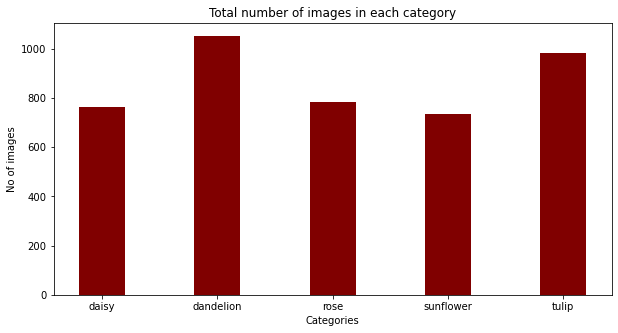

In [3]:
dir = 'flowers'
classes = ['daisy','dandelion','rose','sunflower','tulip']
values = []
total_images = 0
for c in classes :
  flower_path = os.path.join(dir,c)
  count = 0
  for path in os.listdir(flower_path):
      count+=1
  values.append(count)
  total_images +=count
print(values)

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(classes, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Categories")
plt.ylabel("No of images")
plt.title("Total number of images in each category")
plt.show()

# Step 2 : Data Preprocessing¶
1. Exploring the dataset, to gain knowledge about the same.
2. Coverting images to nd-array, then combining them with their labels and dumping it into a single file.
3. Normalizing the nd-array images.

We need to convert the images into nd-arrays .The next step is to combine all the image numpy arrays with their labels, into a common file, so as to make the training and testing process easier."

In [27]:
def prepare_dataset():
    record = []
    for c in classes:
        path = os.path.join(dir, c)
        lable = classes.index(c)
    
        for img_name in os.listdir(path):
            image_path = os.path.join(path, img_name)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224,224))
            image = np.array(image, dtype=np.float32)
            #print(image)
            record.append([image, lable])
            
    #print(record)
    img_pic = open('data.pickle','wb')
    pickle.dump(record, img_pic)
    img_pic.close()

In [28]:
prepare_dataset()

Normalize the image arrays to prepare it for training.

In [29]:
def load_dataset():
    img_pic = open('data.pickle','rb')
    data = pickle.load(img_pic)
    img_pic.close()
    
    np.random.shuffle(data)
    feature = []
    lables = []
    
    for img,lable in data:
        feature.append(img)
        lables.append(lable)
    feature = np.array(feature, dtype=np.float32)
    lables = np.array(lables)
    
    feature = feature/255.0
    return [feature, lables]

# Step 3 : Model Preparation, Training and Testing
1. Split the data into training and testing samples.
2. Reviewing the training data.
3. Preparing convolutional and pooling layers in the model.
4. Precautionary steps to avoid overfitting.
5. Training the model.
6. Saving the model in google drive.

In [30]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [33]:
(feature,labels) = load_dataset()
X_train, X_test, Y_train, Y_test = train_test_split(feature,labels,test_size = 0.1,random_state=42)
classes = ['daisy','dandelion','rose','sunflower','tulip']

Viewing some of the data samples from the training split, to ensure proper working without errors.

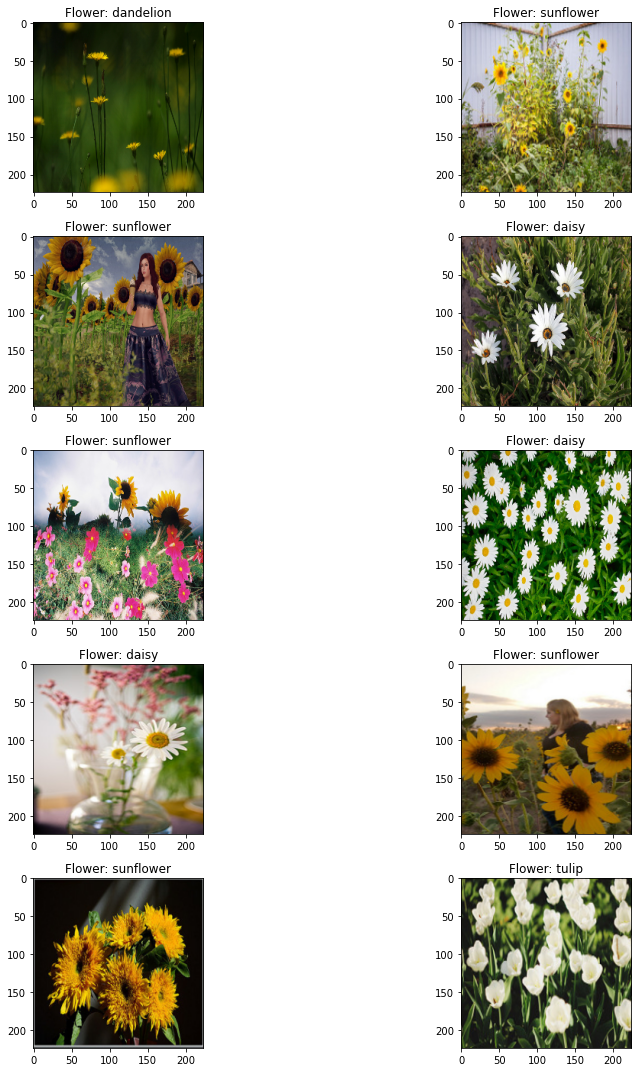

In [34]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(X_test))
        ax[i,j].imshow(X_test[l])
        ax[i,j].set_title('Flower: '+classes[Y_test[l]])
        
plt.tight_layout()

Adding the input layer to the model, followed by layers of 2D convolutional neural netorks and max pooling. Finsihing with an output layer at the end after the dense layer.

In [35]:
input_layer = tf.keras.layers.Input([224,224,3])

conv1 = tf.keras.layers.Conv2D(filters = 32,kernel_size=(5,5),padding='Same',activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3),padding='Same',activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv2)

conv3 = tf.keras.layers.Conv2D(filters = 96, kernel_size=(3,3),padding='Same',activation='relu')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv3)

conv4 = tf.keras.layers.Conv2D(filters = 96, kernel_size=(3,3),padding='Same',activation='relu')(pool3)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv4)

flt1 = tf.keras.layers.Flatten()(pool4)

dn1 = tf.keras.layers.Dense(512,activation='relu')(flt1)
output_layer = tf.keras.layers.Dense(5,activation='softmax')(dn1)

In [66]:
# MODEL
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
# COMPILE
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Performing data augmentation to avoid model overfitting.

In [67]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [68]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 220, 220, 32)      2432      
_________________________________________________________________
activation_17 (Activation)   (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 108, 108, 32)      9248      
_________________________________________________________________
activation_18 (Activation)   (None, 108, 108, 32)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 52, 64)       

raining the model on the training dataset, for 20 epochs and a batch_size of 100.

In [69]:
batch_size = 100
epochs = 20

History = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

C:\Users\Rohan\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
38/38 [==============================] - 213s 6s/step - loss: 1.4565 - accuracy: 0.3593 - val_loss: 1.1764 - val_accuracy: 0.4722
Epoch 2/20
38/38 [==============================] - 279s 7s/step - loss: 1.1927 - accuracy: 0.4962 - val_loss: 1.1059 - val_accuracy: 0.5532
Epoch 3/20
38/38 [==============================] - 282s 7s/step - loss: 1.0921 - accuracy: 0.5641 - val_loss: 0.9422 - val_accuracy: 0.6366
Epoch 4/20
38/38 [==============================] - 289s 8s/step - loss: 1.0051 - accuracy: 0.6071 - val_loss: 0.9363 - val_accuracy: 0.6389
Epoch 5/20
38/38 [==============================] - 340s 9s/step - loss: 0.9742 - accuracy: 0.6108 - val_loss: 0.9306 - val_accuracy: 0.6412
Epoch 6/20
38/38 [==============================] - 320s 8s/step - loss: 0.9184 - accuracy: 0.6468 - val_loss: 0.9318 - val_accuracy: 0.6319
Epoch 7/20
38/38 [==============================] - 317s 8s/step - loss: 0.8996 - accuracy: 0.6547 - val_loss: 0.9382 - val_accuracy: 0.6366
Epoch 8/20
38

In [70]:
model.save('flower_v1.h5')

# Step 4 : Model Evaluation¶
1. Evaluating the model's accuracy on the testing dataset.
2. Viewing the model's results for some random data from the testing split.
3. Checking model's performance on a random image from the internet.
4. Calculating accuracy, precision, recall, f1 score and plotting the confusion matrix for the model.

In [71]:
model.evaluate(X_test, Y_test, verbose=1)

14/14 [==============================] - 6s 428ms/step - loss: 0.6070 - accuracy: 0.7801


[0.6069884896278381, 0.7800925970077515]

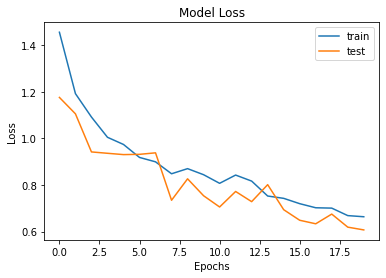

In [72]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

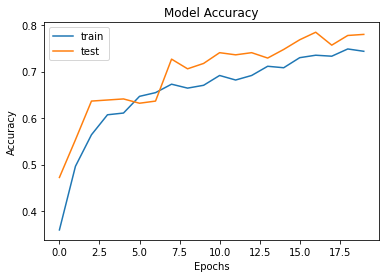

In [73]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Making predictions on the test dataset and plotting the results to verify.

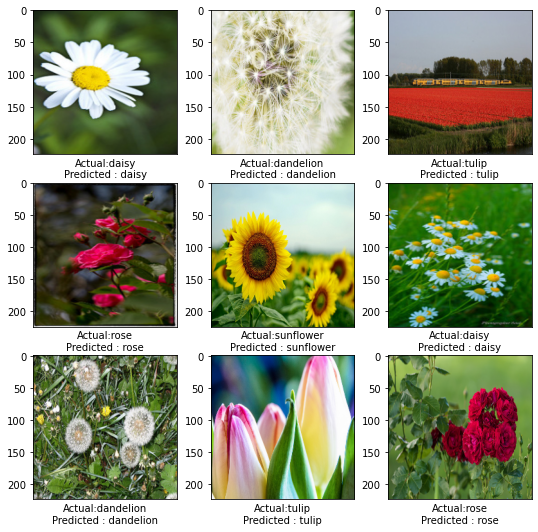

In [75]:
predictions = model.predict(X_test)
plt.figure(figsize=(9,9))

for i in range(9) :
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.xlabel('Actual:'+classes[Y_test[i]]+'\n'+'Predicted : '+classes[np.argmax(predictions[i])])
    plt.xticks([])
plt.show()

### Testing the model's accuracy on a random image from the internet.

[[0.00227732 0.00801693 0.00309444 0.9833477  0.00326352]]
3


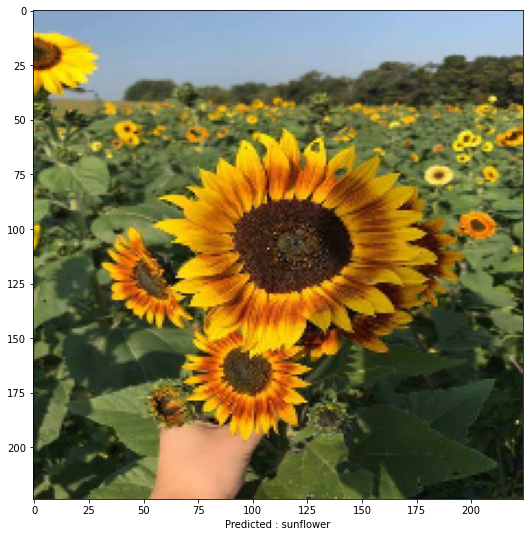

In [81]:
pred_image_path = 'test_sunflower.jpg'
pred_image = cv2.imread(pred_image_path)
pred_image = cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB)
pred_image = cv2.resize(pred_image,(224,224))

# print(pred_image)

pred_image = np.array(pred_image,dtype=np.float32)
feat = []
lab = []
feat.append(pred_image)
lab.append('rose')

feat = np.array(feat,dtype=np.float32)
lab = np.array(lab)
feat = feat/255.0
preds = model.predict(feat)
print(preds)
plt.figure(figsize=(9,9))
plt.imshow(feat[0])
plt.xlabel('Predicted : '+classes[np.argmax(preds)])
print(np.argmax(preds))

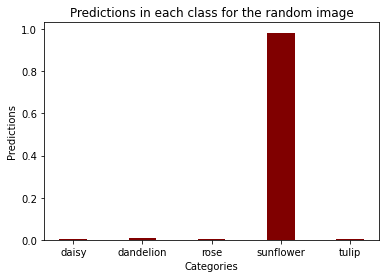

In [82]:
values = []
for i in preds[0] :
  values.append(float(i))
plt.bar(classes,values, color ='maroon', width = 0.4)
 
plt.xlabel("Categories")
plt.ylabel("Predictions")
plt.title("Predictions in each class for the random image")
plt.show()

In [83]:
## Model Evaluation
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

In [84]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

### Plotting the confusion matrix based on the results obtained from evaluating the test dataset.

In [86]:
predictions = model.predict(X_test)

obtained = []
truth = []
for i in range(len(predictions)) : 
    obtained.append(classes[np.argmax(predictions[i])])
    truth.append(classes[Y_test[i]])
cm = confusion_matrix(truth,obtained)

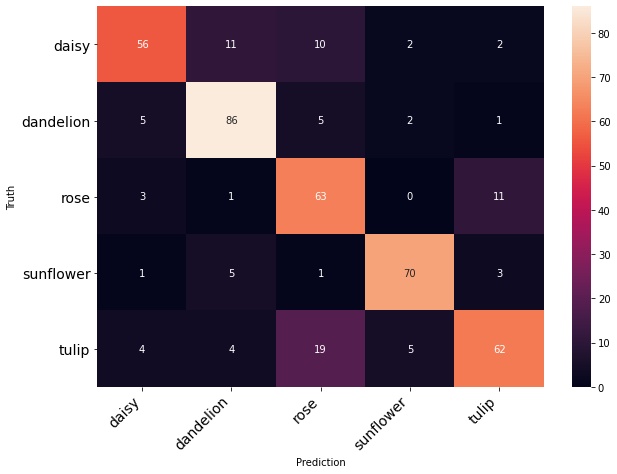

In [87]:
print_confusion_matrix(cm,['daisy','dandelion','rose','sunflower','tulip'])

### Classification report providing with the precision, recall and f1-score for the model.

In [89]:
print(classification_report(truth,obtained))

              precision    recall  f1-score   support

       daisy       0.81      0.69      0.75        81
   dandelion       0.80      0.87      0.83        99
        rose       0.64      0.81      0.72        78
   sunflower       0.89      0.88      0.88        80
       tulip       0.78      0.66      0.72        94

    accuracy                           0.78       432
   macro avg       0.79      0.78      0.78       432
weighted avg       0.79      0.78      0.78       432

